(data_container)=
# Using Data Containers

:::{post} Dec 16, 2021
:tags: posterior predictive, shared data 
:category: beginner
:author: Juan Martin Loyola, Kavya Jaiswal, Oriol Abril, Jesse Grabowski
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from numpy.random import default_rng

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = sum(map(ord, "Data Containers in PyMC"))
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Introduction

The {class}`pymc.Data` container allows users to keep track of dimensions (like dates or cities) and coordinates (such as the actual date times or city names) of multi-dimensional data. It offers two wrappers for this: {class}`pymc.ConstantData` and {class}`MutableData`. Both allow you to specify the dimension names and coordinates of random variables, instead of specifying the shapes of those random variables as numbers. The difference is whether you intend to change this data after fitting the model, to perform out-of-sample prediciton, for example. 

In past versions of PyMC, the only data container was `pm.Data`. This container is still available for backwards compatability, but the current best practice is to use either `pm.MutableData` or `pm.ConstantData`, depending on your needs.  This notebook will demonstrate how each of these containers are used, and when they are appropriate.

## Constant Data

The `pm.ConstantData` is a way to add fixed data to a model. It provides a speed boost in exchange for the ability to change the data. If you don't plan on doing out-of-sample prediction, `pm.ConstantData` is for you. 

In the following example, the usage of `pm.ConstantData` is demonstrated with fictional temperature observations.

In [3]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-05-20")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = rng.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

,Berlin,San Marino,Paris
date,,,
2020-05-01,15.002204,19.258310,14.332119
2020-05-02,14.866713,19.414908,15.876674
2020-05-03,16.551536,16.955090,16.969259
2020-05-04,14.602043,17.803968,16.654254
2020-05-05,15.645944,18.999811,15.644492


As noted above, `ConstantData` gives you the ability to give named labels to the dimensions of your data. This can be done in two ways:  

- Entering the dimensions in the `dims` kwarg of a `pm.ConstantData` variable with a pandas Series or DataFrame. The name of the index and columns will be remembered as the dimensions, and PyMC will infer that the values of the given columns must be the coordinates.
- Using the new `coords` argument to {class}`pymc.Model` to set the coordinates explicitly.

For more explanation about dimensions, coordinates and their big benefits, we encourage you to take a look at the {ref}`ArviZ documentation <arviz:xarray_for_arviz>`.

This is a lot of explanation -- let's see how it's done! We will use a hierarchical model: it assumes a mean temperature for the European continent and models each city relative to the continent mean:

In [4]:
# The data has two dimensions: date and city
coords = {"date": df_data.index, "city": df_data.columns}

In [5]:
with pm.Model(coords=coords) as model:
    europe_mean = pm.Normal("europe_mean_temp", mu=15.0, sigma=3.0)
    city_offset = pm.Normal("city_offset", mu=0.0, sigma=3.0, dims="city")
    city_temperature = pm.Deterministic("city_temperature", europe_mean + city_offset, dims="city")

    data = pm.ConstantData("data", df_data, dims=("date", "city"))
    pm.Normal("likelihood", mu=city_temperature, sigma=0.5, observed=data, dims=("date", "city"))

    idata = pm.sample(
        target_accept=0.85,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [europe_mean_temp, city_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
/Users/jessegrabowski/mambaforge/envs/pymc-experimental/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


We can plot the digraph for our model using:

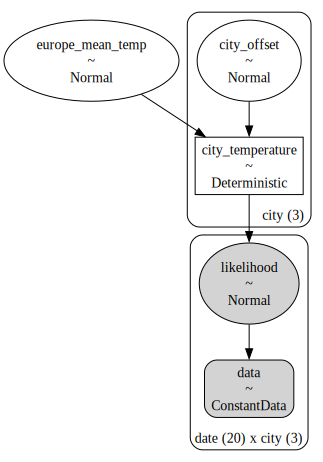

In [6]:
pm.model_to_graphviz(model)

And we see that the model did remember the coords we gave it:

In [7]:
model.coords

{'date': (Timestamp('2020-05-01 00:00:00'),
  Timestamp('2020-05-02 00:00:00'),
  Timestamp('2020-05-03 00:00:00'),
  Timestamp('2020-05-04 00:00:00'),
  Timestamp('2020-05-05 00:00:00'),
  Timestamp('2020-05-06 00:00:00'),
  Timestamp('2020-05-07 00:00:00'),
  Timestamp('2020-05-08 00:00:00'),
  Timestamp('2020-05-09 00:00:00'),
  Timestamp('2020-05-10 00:00:00'),
  Timestamp('2020-05-11 00:00:00'),
  Timestamp('2020-05-12 00:00:00'),
  Timestamp('2020-05-13 00:00:00'),
  Timestamp('2020-05-14 00:00:00'),
  Timestamp('2020-05-15 00:00:00'),
  Timestamp('2020-05-16 00:00:00'),
  Timestamp('2020-05-17 00:00:00'),
  Timestamp('2020-05-18 00:00:00'),
  Timestamp('2020-05-19 00:00:00'),
  Timestamp('2020-05-20 00:00:00')),
 'city': ('Berlin', 'San Marino', 'Paris')}

Coordinates are automatically stored into the {class}`arviz.InferenceData` object:

In [8]:
idata.posterior.coords

Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * city     (city) <U10 'Berlin' 'San Marino' 'Paris'

/Users/jessegrabowski/mambaforge/envs/pymc-experimental/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


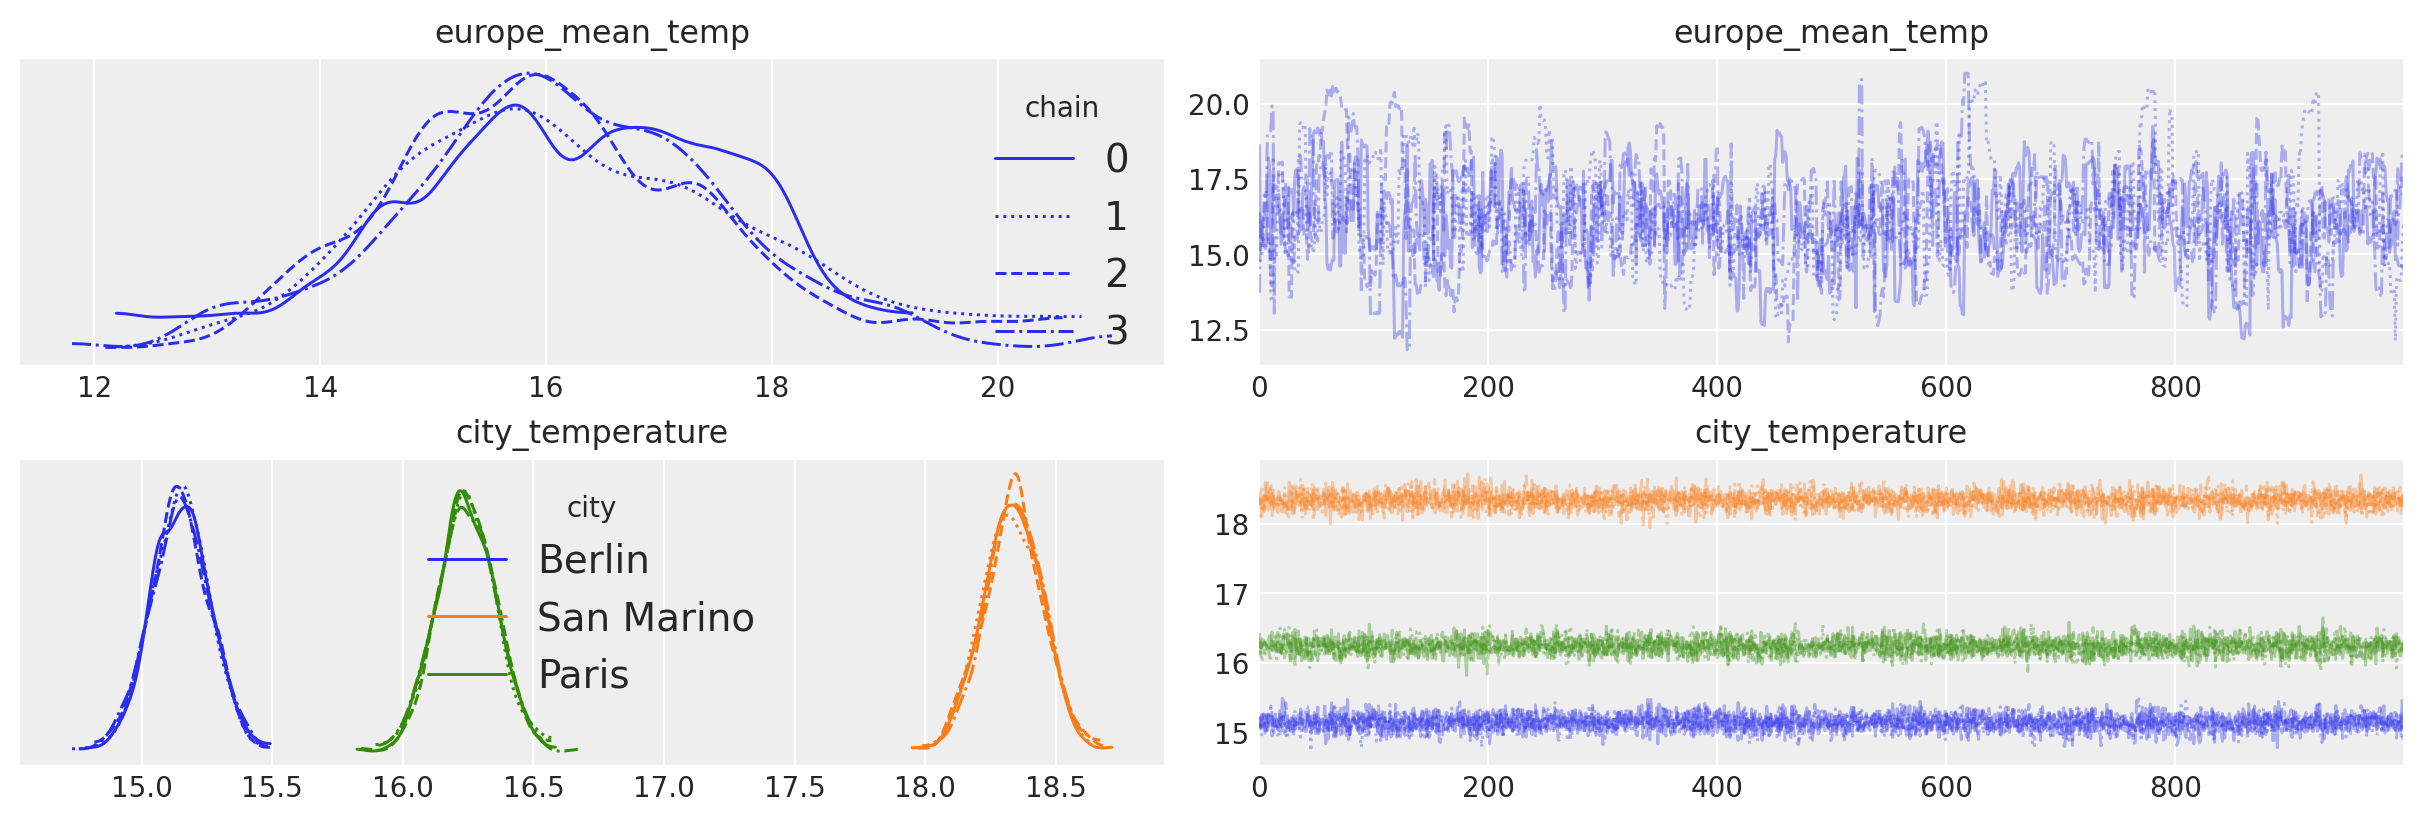

In [9]:
axes = az.plot_trace(idata, var_names=["europe_mean_temp", "city_temperature"], legend=True);

When we use `pm.ConstantData`, the data are internally represented as a pytensor `TensorConstant`.

In [10]:
type(data)

pytensor.tensor.var.TensorConstant

If you need to, you can view the data using the `data` method. All `PyMC` variables, including `Data` containers, can be accessed by indexing the model object with a variable name. Since this line:

```python
    data = pm.ConstantData("data", df_data, dims=("date", "city"))
```

Gave the name "data" to the data, we can access it as follows: 

In [11]:
model["data"].data

array([[15.00220396, 19.25831025, 14.33211944],
       [14.86671305, 19.4149082 , 15.8766739 ],
       [16.55153648, 16.9550901 , 16.96925899],
       [14.60204286, 17.80396838, 16.65425367],
       [15.64594381, 18.9998107 , 15.64449245],
       [15.42259708, 18.56112648, 14.84095277],
       [15.92039794, 19.69454505, 15.01067574],
       [15.4522671 , 17.68912429, 16.07197773],
       [14.38674089, 18.63932036, 16.44000867],
       [12.91281241, 19.10362994, 16.78763687],
       [15.8089247 , 18.57415378, 15.76664529],
       [16.12240673, 17.767245  , 16.34047793],
       [16.06213378, 18.34432903, 15.70967571],
       [15.01398531, 17.64898318, 15.86959189],
       [15.43016594, 18.03374707, 15.27811714],
       [14.49832197, 18.50812944, 17.42903693],
       [12.69850156, 17.59117357, 16.47672622],
       [16.83456774, 18.19803062, 17.99985688],
       [13.99756283, 17.43381256, 17.34261361],
       [15.71777757, 18.59168733, 18.01941119]])

## MutableData

In many cases, you will want the ability to switch out data between model runs. This arises when you want to fit a model to multiple datasets, or if you are interested in out-of-sample prediction. For these cases, `pm.MutableData` is the correct tool.

### Using MutableData container variables to fit the same model to several datasets

We can use `MutableData` container variables in PyMC to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large):

In [12]:
# We generate 10 datasets
true_mu = [rng.random() for _ in range(10)]
observed_data = [mu + rng.random(20) for mu in true_mu]

with pm.Model() as model:
    data = pm.MutableData("data", observed_data[0])
    mu = pm.Normal("mu", 0, 10)
    pm.Normal("y", mu=mu, sigma=1, observed=data)

Once again, the name of our data is `data`, so we can look at it's type. Unlike `pm.ConstantData`, we now see a {meth}`pytensor.compile.sharedvalue.SharedVariable.get_value` of class {class}`pytensor.compile.sharedvalue.SharedVariable` to get the value of the variable. This is because our data is now a `SharedVariable`.

In [13]:
type(model["data"])

pytensor.tensor.sharedvar.TensorSharedVariable


The methods and functions related to the Data container class are:

- {meth}`data_container.get_value <pytensor.compile.sharedvalue.SharedVariable.get_value>` (method inherited from the pytensor SharedVariable): gets the value associated with the `data_container`.
- {meth}`data_container.set_value <pytensor.compile.sharedvalue.SharedVariable.set_value>` (method inherited from the pytensor SharedVariable): sets the value associated with the `data_container`.
- {func}`pymc.set_data`: PyMC function that sets the value associated with each Data container variable indicated in the dictionary `new_data` with it corresponding new value.

Here we use the `get_value` method to see the data stored in the container:

In [14]:
model["data"].get_value()

array([0.53325769, 0.7385456 , 0.47488452, 1.17345368, 1.27390353,
       0.82661052, 0.80201453, 0.97747621, 1.07293285, 0.60756608,
       0.33528567, 0.45235047, 0.67656513, 1.31228895, 0.57776931,
       0.85691851, 0.89171478, 0.89283216, 0.60778823, 1.27978813])

In practice, however, you will not need to use `get_value()` or `set_value()`. Instead, it is best to use {func}`pymc.set_data`. Let's use the `MutableData` to repeatedly fit the same model to multiple datasets: 

In [15]:
# Generate one trace for each dataset
traces = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        traces.append(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


### Using MutableData container variables to predict on new data

A common task in machine learning is to predict values for unseen data, and the `MutableData` container variable is exactly what we need to do this. 

One small detail to pay attention to in this case is that the shapes of the input data (`x`) and output data (`obs`) must be the same. When we make out-of-sample predictions, we typically change only the input data, the shape of which may not be the same as the training observations. Naively changing only one will result in a shape error. There are two solutions:

1. Use a `pm.MutableData` for the `x` data and the `y` data, and use `pm.set_data` to change `y` to something of the same shape as the test inputs. 
2. Tell PyMC that the shape of the `obs` should always be the shape of the input data.

In the next model, we use option 2. This way, we don't need to pass dummy data to `y` every time we want to change `x`.

In [16]:
x = rng.random(100)
y = x > 0

with pm.Model() as model:
    x_shared = pm.MutableData("x_shared", x)
    coeff = pm.Normal("x", mu=0, sigma=1)

    logistic = pm.math.sigmoid(coeff * x_shared)

    # Here is were we link the shapes of the inputs (x_shared) and the output
    pm.Bernoulli("obs", p=logistic, observed=y, shape=x_shared.shape[0])

    # fit the model
    trace = pm.sample(return_inferencedata=True, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


In [17]:
new_values = [-1, 0, 1.0]
with model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    # We do not need to set data for the outputs because we told the model to always link the shape of the output to the shape
    # of the input.
    pm.set_data({"x_shared": new_values})
    post_pred = pm.sample_posterior_predictive(trace)

Sampling: [obs]


The same concept applied to a more complex model can be seen in the notebook {ref}`bayesian_neural_network_advi`.

## Applied example: height of toddlers as a function of age

This example is taken from Osvaldo Martin's book: [Bayesian Analysis with Python: Introduction to statistical modeling and probabilistic programming using PyMC and ArviZ, 2nd Edition](https://www.amazon.com/Bayesian-Analysis-Python-Introduction-probabilistic-ebook/dp/B07HHBCR9G) {cite:p}`martin2018bayesian`.

The World Health Organization and other health institutions around the world collect data
for newborns and toddlers and design [growth charts standards](http://www.who.int/childgrowth/en/). These charts are an essential component of the paediatric toolkit and also as a measure of the general well-being of
populations in order to formulate health policies, and plan interventions and
monitor their effectiveness.

An example of such data is the lengths (heights) of newborn / toddler girls as a function of age (in months):

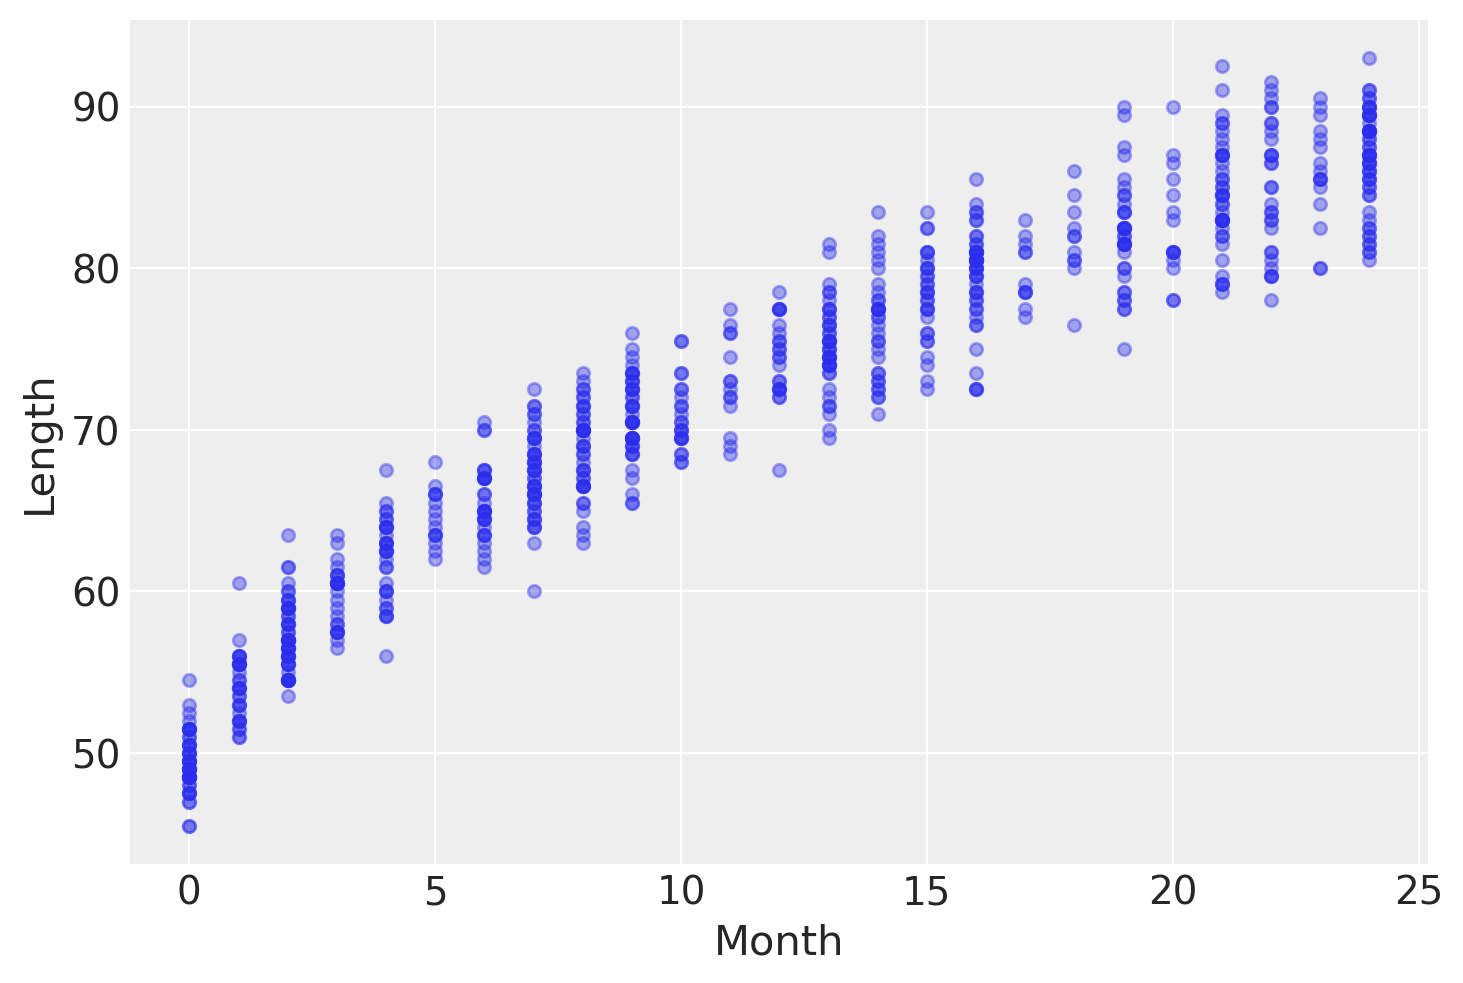

In [18]:
try:
    data = pd.read_csv("../data/babies.csv")
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("babies.csv"))
data.plot.scatter("Month", "Length", alpha=0.4);

To model this data, we will introduce one new feature: mutable `coords`. When we know we have a coord that is going to need to change in the future, like the index of data we will change between training and test sets, we can set the model `coords` via the `coords_mutable` keyword argument.

You are also allowed to specify both `coords` and `coords_mutable` in the same model. In this next model, we will always have the same parameters, so the `parameters` coord is specified as constant via `coords`, while the `obs_idx` will change when we go to do out-of-sample prediction.  

Finally, we plan to use to use this model to do some out-of-sample prediction. Thus, we will opt for `pm.MutableData` as the data container. Note that we are allowed to label the dimensions of a `pm.MutableData` just like `pm.ConstantData`.

In [19]:
with pm.Model(
    coords_mutable={"obs_idx": np.arange(len(data))}, coords={"parameter": ["intercept", "slope"]}
) as model_babies:
    mean_params = pm.Normal("mean_params", sigma=10, dims=["parameter"])
    sigma_params = pm.Normal("sigma_params", sigma=10, dims=["parameter"])
    month = pm.MutableData("month", data.Month.values.astype(float), dims=["obs_idx"])

    mu = pm.Deterministic("mu", mean_params[0] + mean_params[1] * month**0.5, dims=["obs_idx"])
    sigma = pm.Deterministic("sigma", sigma_params[0] + sigma_params[1] * month, dims=["obs_idx"])

    length = pm.Normal("length", mu=mu, sigma=sigma, observed=data.Length, dims=["obs_idx"])

    idata_babies = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_params, sigma_params]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


The following figure shows the result of our model. The expected length, $\mu$, is represented with a blue curve, and two semi-transparent orange bands represent the 60% and 94% highest posterior density intervals of posterior predictive length measurements:

In [20]:
with model_babies:
    pm.sample_posterior_predictive(idata_babies, extend_inferencedata=True)

Sampling: [length]


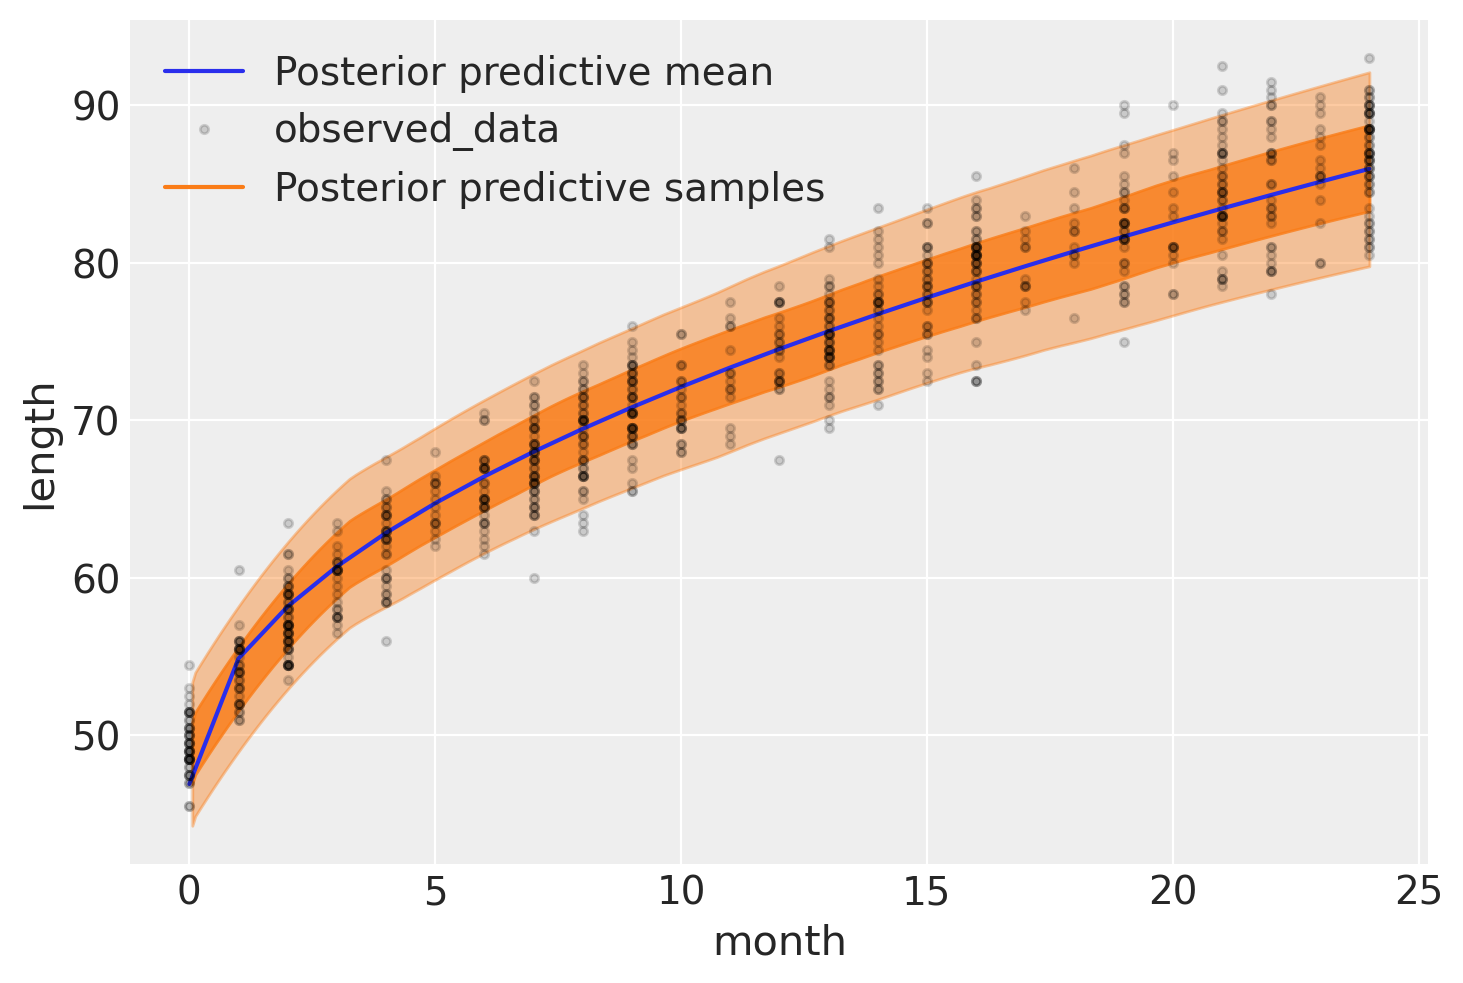

In [21]:
ax = az.plot_hdi(
    data.Month,
    idata_babies.posterior_predictive["length"],
    hdi_prob=0.6,
    fill_kwargs={"alpha": 0.8},
)
ax.plot(
    data.Month,
    idata_babies.posterior["mu"].mean(("chain", "draw")),
    label="Posterior predictive mean",
)
ax = az.plot_lm(
    idata=idata_babies,
    y="length",
    x="month",
    kind_pp="hdi",
    y_kwargs={"color": "k", "ms": 6, "alpha": 0.15},
    y_hat_fill_kwargs=dict(fill_kwargs={"alpha": 0.4}),
    axes=ax,
)

At the moment of writing Osvaldo's daughter is two weeks ($\approx 0.5$ months) old, and thus he wonders how her length compares to the growth chart we have just created. One way to answer this question is to ask the model for the distribution of the variable length for babies of 0.5 months. Using PyMC we can ask this questions with the function `sample_posterior_predictive` , as this will return samples of _Length_ conditioned on the obseved data and the estimated distribution of parameters, that is including uncertainties. 

The only problem is that by default this function will return predictions for _Length_ for the observed values of _Month_, and $0.5$ months (the value Osvaldo cares about) has not been observed, -- all measures are reported for integer months. The easier way to get predictions for non-observed values of _Month_ is to pass new values to the `Data` container we defined above in our model. To do that, we need to use `pm.set_data` and then we just have to sample from the posterior predictve distribution. We will also have to set `coords` for these new observations, which we are allowed to do in the `pm.set_data` function because we have set the `obs_idx` coord as mutable. 

Note that the actual value we pass for `obs_idx` is totally irrevelant *in this case*, so we give it a value of 0. What is important is that we update it to have the same length as the ages we want to do out-of-sample prediction for, and that each age has a unique index identifier.

In [22]:
ages_to_check = [0.5]
with model_babies:
    pm.set_data({"month": ages_to_check}, coords={"obs_idx": [0]})

    # Setting predictions=True will add a new "predictions" group to our idata. This lets us store the posterior,
    # posterior_predictive, and predictions all in the same object.
    idata_babies = pm.sample_posterior_predictive(
        idata_babies, extend_inferencedata=True, predictions=True
    )

Sampling: [length]


Now we can plot the expected distribution of lengths for 2-week old babies and compute additional quantities -- for example the percentile of a child given her length. Here, let's imagine that the child we're interested in has a length of 51.5:

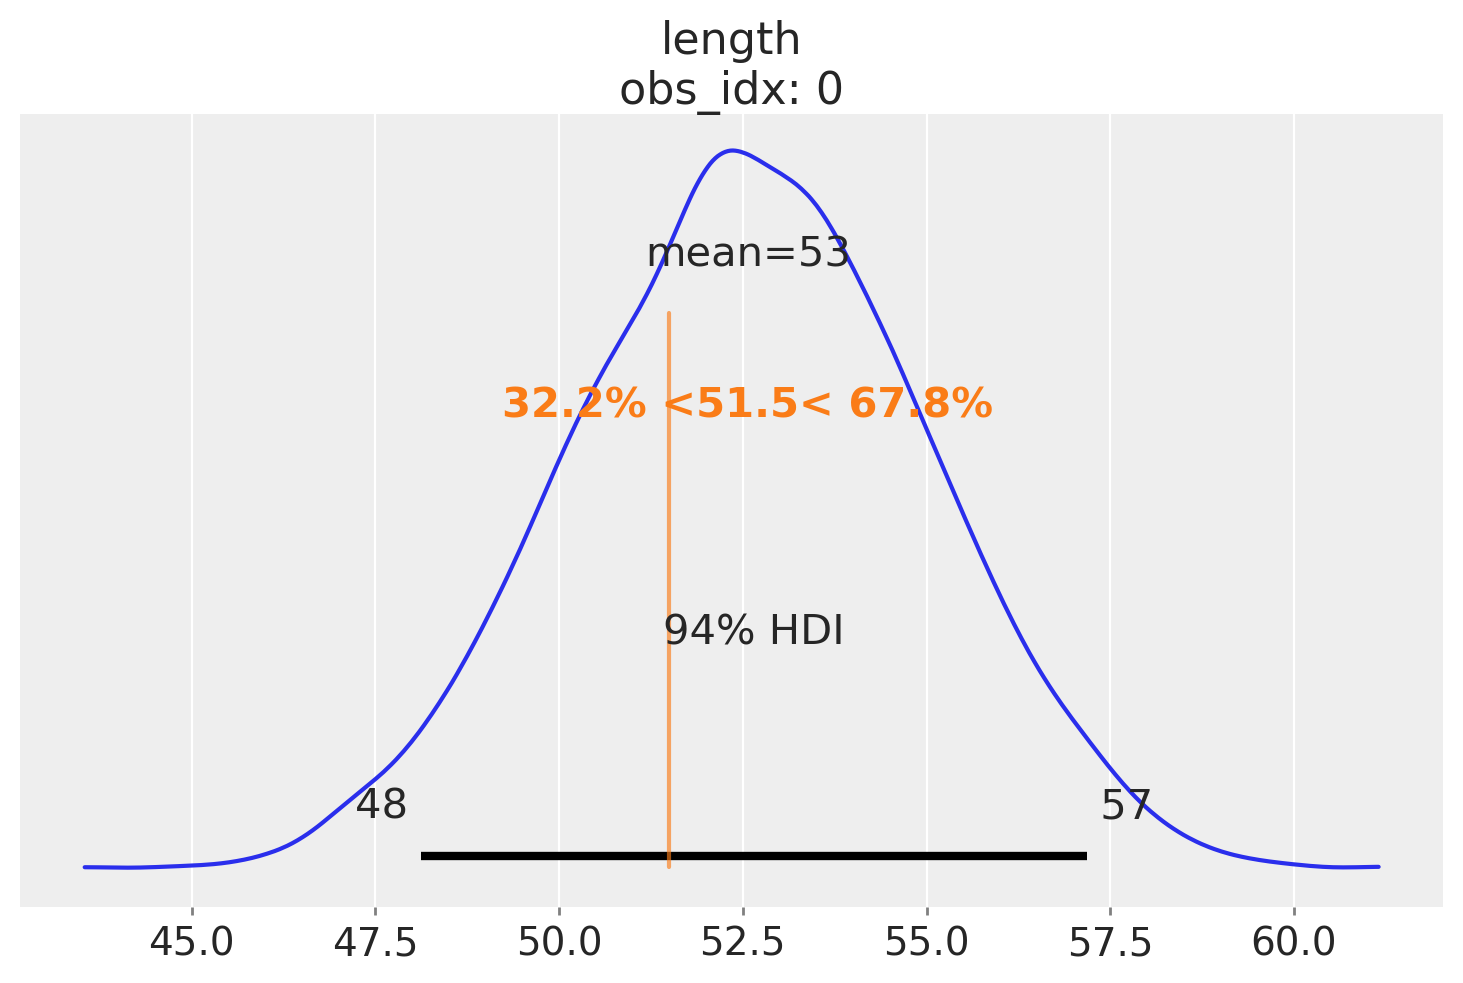

In [23]:
ref_length = 51.5

az.plot_posterior(
    idata_babies,
    group="predictions",
    ref_val={"length": [{"ref_val": ref_length}]},
    labeller=az.labels.DimCoordLabeller(),
);

## Authors
* Authored by [Juan Martin Loyola](https://github.com/jmloyola) in March, 2019 ([pymc#3389](https://github.com/pymc-devs/pymc/pull/3389))
* Updated by [Kavya Jaiswal](https://github.com/KavyaJaiswal) and [Oriol Abril](https://github.com/OriolAbril) in December, 2021 ([pymc-examples#151](https://github.com/pymc-devs/pymc-examples/pull/151))
* Updated by [Jesse Grabowski](https://github.com/jessegrabowski) in July 2023 ([pymc-examples#559](https://github.com/pymc-devs/pymc-examples/pull/559))

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Fri Jul 14 2023

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

pytensor: 2.12.3
xarray  : 2023.6.0

arviz     : 0.15.1
pandas    : 2.0.3
pymc      : 5.6.0
matplotlib: 3.7.2
numpy     : 1.24.4

Watermark: 2.4.3



:::{include} ../page_footer.md
:::